In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ, execute
from qiskit.circuit import Parameter
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
nqubits = 16

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
#qc_mix.draw()

In [3]:
M = 3 # number of cells
K = 3 # number of users
rho = 1 # max power
BW_max = 8 # max BW, M_hat in paper
eta = np.random.rand(K) # power control fraction for each user
alpha = np.random.rand(M,K)
beta = np.random.rand(M,K)

In [4]:
#tg = 10.0 ** np.array([-3.2, -3, -2.8, -2.6, -2.4, -2.2, -2., -1.8, -1.6, -1.4, -1.2, -1, -0.8, -0.6, -0.4, -0.2, 0, 1, 2, 3])
tg = 10.0 ** np.array([ -3, -2.5, -2., -1.5, -1, -0.5, 0])
Nt = len(tg)
x_t = np.zeros(Nt)

X_mat = np.zeros((M,K))
x_vec = X_mat.flatten('F')
x = np.concatenate((x_vec,x_t))

In [5]:
Pt = np.concatenate((np.zeros((Nt,M*K)),np.eye(Nt)), axis = 1)
Pk_list = []
for k in range(K):
    Pk = np.concatenate((np.zeros((M,M*k)), np.eye(M), np.zeros((M,M*(K-k-1)+Nt))), axis = 1 )
    Pk_list.append(Pk)
Pm_list = []
for m in range(M):
    Pm = np.zeros((K,M*K+Nt))
    for k in range(K):
        Pm[k,m+M*k] = 1
    Pk_list.append(Pm)
    
one_vec = np.ones(M*K+Nt)
one_vec_tilde = np.concatenate((np.ones(M*K),np.zeros(Nt)))

In [6]:
# build A and B

A_list = []
B_list = []

b_tilde_list = []
A_tilde_list = []

for k in range(K):
    A_tilde = np.zeros((M,M))
    b_tilde = np.zeros(M)

    for m in range(M):
        for n in range(M):
            A_tilde[m,n] = rho*eta[k]*alpha[m,k]*alpha[n,k]
        b_tilde[m] = alpha[m,k]*(rho*(np.sum(np.multiply(eta,beta[m,:])) - beta[m,k]*eta[k]) + 1)
    
    A_tilde_list.append(A_tilde)
    b_tilde_list.append(b_tilde)
    
    A_list.append( Pk_list[k].T@A_tilde@Pk_list[k] )
    B_list.append( np.outer((Pt.T @ tg),(b_tilde.T @ Pk_list[k])) )
    
    

In [7]:
C = np.sum( [ A_list[k] - B_list[k] for k in range(len(A_list)) ] , 0 )
EM = np.ones((M,M))
EMK = np.ones((M*K,M*K))
IK = np.eye(K)
D = np.kron(IK,EM)

print(C.shape)
print(EM.shape)
print(D.shape)
print(D)

(16, 16)
(3, 3)
(9, 9)
[[1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]]


In [8]:
c_bar = np.sum(C,0)
c_tilde = np.sum(C,1)

print(c_tilde)
print(c_bar)
print(np.sum(C[:,0]))
print(np.sum(C[0,:]))

[ 1.17265003e+00  1.15620127e+00  1.71106172e+00  6.49787518e-02
  6.46566275e-02  8.95740753e-02  8.52082926e-02  1.85540095e-02
  1.17966178e-01 -6.10439394e-03 -1.93037886e-02 -6.10439394e-02
 -1.93037886e-01 -6.10439394e-01 -1.93037886e+00 -6.10439394e+00]
[-0.18875177 -0.37451419 -0.77656075 -0.56292432 -0.71031228 -0.95914276
 -0.31837708 -0.0887792  -0.46448888  0.          0.          0.
  0.          0.          0.          0.        ]
-0.18875176681545147
1.1726500276208578


In [9]:
F = np.block( [[ C[0:(M*K),0:(M*K)]+D-EMK, np.zeros((M*K,Nt)) ], [ np.zeros((Nt,M*K)), np.eye(Nt) ]] )

In [10]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for i in range(M*K+Nt):  # pairs of nodes
    for j in range(M*K+Nt):
        if(i != j and abs(F[i,j])>10**(-10)):
            qc_p.rzz(2 * gamma * F[i,j], i, j)
            qc_p.barrier()
    
for i in range(M*K+Nt):
    coef = c_tilde[i] + c_bar[i]
    if(i > M*K):
        coef += tg[i-M*K]
    if(abs(coef) > 10**(-10)):
        qc_p.rz(2 * gamma * coef, i)
    
print(qc_p.depth())
#qc_p.decompose().draw()

73


In [11]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
#qc_0.draw()

In [12]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

#qc_qaoa.decompose().decompose().draw()

In [13]:
def problem_objective(x, tg, Pt):
    
    # convert x to binary vector
    xv = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] == '1':
            xv[i] = 1
    
    obj = tg.T @ (Pt @ xv)
    
    return -obj  # we minimize

def compute_expectation(counts, tg, Pt):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = problem_objective(bitstring, tg, Pt)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(M,K,BW_max,Nt, tg, F, c_bar, c_tilde, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    lambda_param = 100 # param that weigh contraints vs objective
    nqubits = M*K+Nt
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    print(beta)
    print(gamma)
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for i in range(M*K+Nt):  # pairs of nodes
            for j in range(M*K+Nt):
                if(i != j and abs(F[i,j])>10**(-10)):
                    qc.rzz(2 * F[i,j].item() * gamma[irep].item(), i, j)
                    

        for i in range(M*K+Nt):
            coef = c_tilde[i] + c_bar[i]
            if(i > M*K):
                coef += tg[i-M*K]/lambda_param
            else:
                coef += 2*(4*BW_max -(M-1)*K -2)
            if(abs(coef) > 10**(-10)):
                qc.rz(2 * gamma[irep].item() * coef, i)

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(M,K,BW_max,Nt, tg, F, c_bar, c_tilde, p, shots=512):
    
    """
    Runs parametrized circuit
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(M,K,BW_max,Nt, tg, F, c_bar, c_tilde, theta)
        counts = backend.run(qc, seed_simulator=10, nshots=512).result().get_counts()
        
        return compute_expectation(counts, tg, Pt)
    
    return execute_circ

In [14]:
from scipy.optimize import minimize


expectation = get_expectation(M,K,BW_max,Nt, tg, F, c_bar, c_tilde, p=4)

res = minimize(expectation, 
                      [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25], 
                      method='COBYLA')
res

[0.25 0.25 0.25 0.25]
[0.25 0.25 0.25 0.25]
[1.25 0.25 0.25 0.25]
[0.25 0.25 0.25 0.25]
[1.25 1.25 0.25 0.25]
[0.25 0.25 0.25 0.25]
[1.25 0.25 1.25 0.25]
[0.25 0.25 0.25 0.25]
[1.25 0.25 0.25 1.25]
[0.25 0.25 0.25 0.25]
[1.25 0.25 0.25 0.25]
[1.25 0.25 0.25 0.25]
[1.25 0.25 0.25 0.25]
[0.25 1.25 0.25 0.25]
[1.25 0.25 0.25 0.25]
[0.25 0.25 1.25 0.25]
[1.25 0.25 0.25 0.25]
[0.25 0.25 0.25 1.25]
[ 1.73737644 -0.32897893 -0.13039426  0.01504886]
[ 0.21412801 -0.15593974  0.05248163  0.10080753]
[ 2.31348344 -0.06228676 -0.58004218 -0.2626769 ]
[ 0.17172525 -0.63578388 -0.18099645 -0.07554655]
[ 1.34595596 -0.18820687 -0.24365888 -0.09821575]
[ 0.1008634  -0.26920436 -0.06078298 -0.01245708]
[ 1.8089388  -1.26227423 -0.04952586  0.15015112]
[ 0.42346429 -0.08459692  0.20154208  0.26788808]
[ 1.82592792 -0.31062782 -0.22933747 -0.07708104]
[ 0.13132398  0.29211826 -0.03789474  0.01269499]
[ 1.74807814 -0.34169202  0.00415744 -0.1940596 ]
[ 0.22435691 -0.16485328  0.06271053  0.11103643]
[ 1.

     fun: -1.1178589193681376
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 76
  status: 1
 success: True
       x: array([ 1.74744903, -0.34644842, -0.09784988, -0.02983002,  0.20013462,
       -0.16628233,  0.06052588,  0.10911776])

In [15]:
from qiskit.visualization import plot_histogram

[ 1.74744903 -0.34644842 -0.09784988 -0.02983002]
[ 0.20013462 -0.16628233  0.06052588  0.10911776]


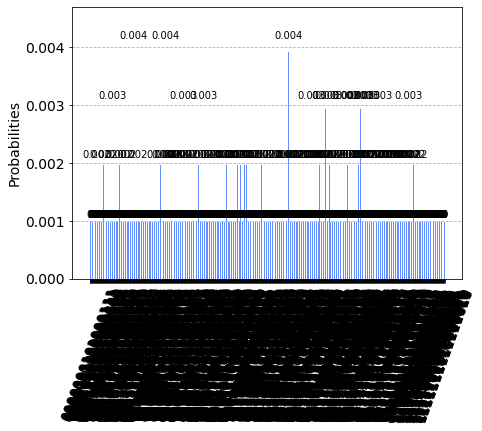

In [16]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(M,K,BW_max,Nt, tg, F, c_bar, c_tilde, res.x)

counts = backend.run(qc_res, seed_simulator=42).result().get_counts()

plot_histogram(counts)

In [17]:
x_best = max(counts, key=counts.get)
v_best = counts[x_best]
print(v_best)
xbest_list = []
[xbest_list.append(k) for k,v in counts.items() if float(v) >= 0.8*v_best]
print(xbest_list)
print([-problem_objective(x_best,tg,Pt) for x_best in xbest_list])

4
['0100001111000111', '0011001111000111', '0110011111001111']
[1.417227766016838, 1.417227766016838, 1.4488505426185219]
